In [2]:
%reload_ext autoreload
%autoreload 2

In [34]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import warnings
import scipy.io as sio
import nelpy as nel

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [16]:
def load_mua(basepath):
    """
    Loads the MUA data from the basepath.
    input:
        basepath: str
            The path to the folder containing the MUA data.
    output:
        mua_data: pandas.DataFrame
            The pandas.DataFrame containing the MUA data

    """

    # locate .mat file
    try:
        filename = glob.glob(basepath+os.sep+'*mua_ca1_pyr.events.mat')[0]
    except:
        # warnings.warn("file does not exist")
        return pd.DataFrame()

    # load matfile
    data = sio.loadmat(filename)

    # pull out and package data
    df = pd.DataFrame()
    df["start"] = data['HSE']["timestamps"][0][0][:, 0]
    df["stop"] = data['HSE']["timestamps"][0][0][:, 1]
    df["peaks"] = data['HSE']["peaks"][0][0]
    df["center"] = data['HSE']["center"][0][0]
    df["duration"] = data['HSE']["duration"][0][0]
    df["amplitude"] = data['HSE']["amplitudes"][0][0]
    df["amplitudeUnits"] = data['HSE']["amplitudeUnits"][0][0][0]
    df["detectorName"] = data['HSE']["detectorinfo"][0][0]["detectorname"][0][0][0]

    # get basename and animal
    normalized_path = os.path.normpath(filename)
    path_components = normalized_path.split(os.sep)
    df["basepath"] = basepath
    df["basename"] = path_components[-2]
    df["animal"] = path_components[-3]

    return df

In [24]:
df = load_mua(r"Z:\Data\AYAold\AB1\day1")
df

,start,stop,peaks,center,duration,amplitude,amplitudeUnits,detectorName,basepath,basename,animal
0,3.188,3.282,3.236,3.2350,0.094,6.358963,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1
1,3.733,3.837,3.788,3.7850,0.104,5.601151,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1
2,6.396,6.517,6.449,6.4565,0.121,4.827183,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1
3,6.633,6.750,6.709,6.6915,0.117,3.287016,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1
4,8.947,9.048,8.982,8.9975,0.101,3.263011,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1
...,...,...,...,...,...,...,...,...,...,...,...
1319,4203.691,4203.767,4203.737,4203.7290,0.076,3.118147,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1
1320,4205.262,4205.333,4205.297,4205.2975,0.071,3.012205,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1
1321,4206.156,4206.255,4206.218,4206.2055,0.099,4.385864,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1
1322,4207.090,4207.356,4207.199,4207.2230,0.266,6.243626,spikes,find_HSE,Z:\Data\AYAold\AB1\day1,day1,AB1


<AxesSubplot:>

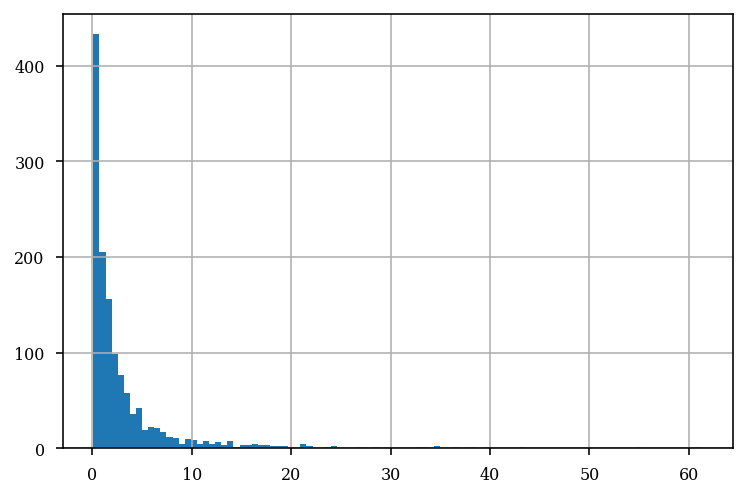

In [23]:
df.peaks.diff().hist(bins=100)

In [108]:
mua_df = loading.load_mua_events(r"Z:\Data\AYAold\AB3\AB3_55_57")
ripple_df = loading.load_ripples_events(r"Z:\Data\AYAold\AB3\AB3_55_57")

In [71]:
# mua_df.stop.loc[-1]

In [109]:
mua_epoch = nel.EpochArray(
    np.array([mua_df.start, mua_df.stop]).T,
    domain=nel.EpochArray([mua_df.start.min(), mua_df.stop.max()]),
)
ripple_epoch = nel.EpochArray(
    np.array([ripple_df.start, ripple_df.stop]).T,
    domain=nel.EpochArray([ripple_df.start.min(), ripple_df.stop.max()]),
)

mua_epoch, ripple_epoch


(<EpochArray at 0x2295ea9a400: 1,902 epochs> of length 6:24:249 minutes,
 <EpochArray at 0x2295e88e520: 1,431 epochs> of length 1:24:476 minutes)

In [74]:
mua_epoch[ripple_epoch.expand(0.05)]

<EpochArray at 0x22955398ca0: 875 epochs> of length 1:34:478 minutes

In [75]:
ripple_epoch[mua_epoch]

<EpochArray at 0x2295bc64d30: 827 epochs> of length 47.6216 seconds

In [76]:
# (ripple_epoch | mua_epoch).merge()
ripple_epoch.intersect(mua_epoch)

<EpochArray at 0x2295e5c1520: 827 epochs> of length 47.6216 seconds

Text(0.5, 1.0, 'MUA epochs with overlap with ripple epochs')

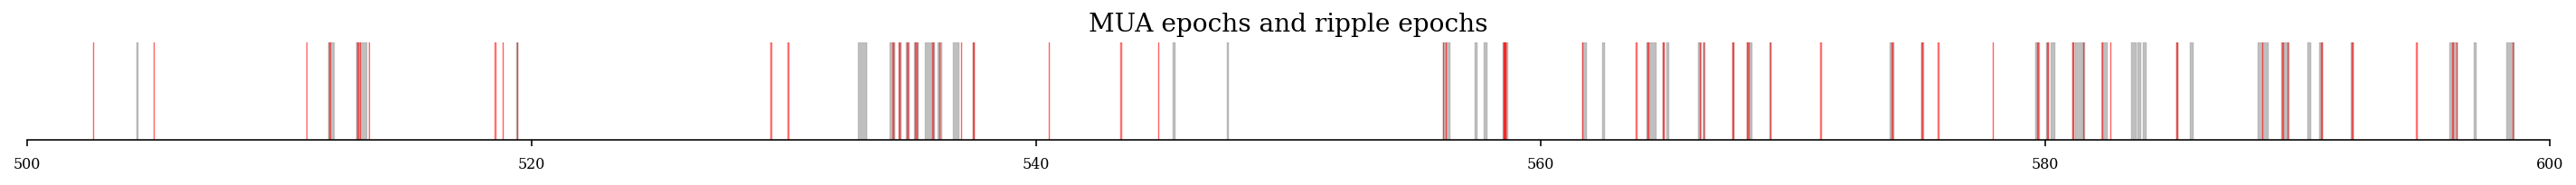

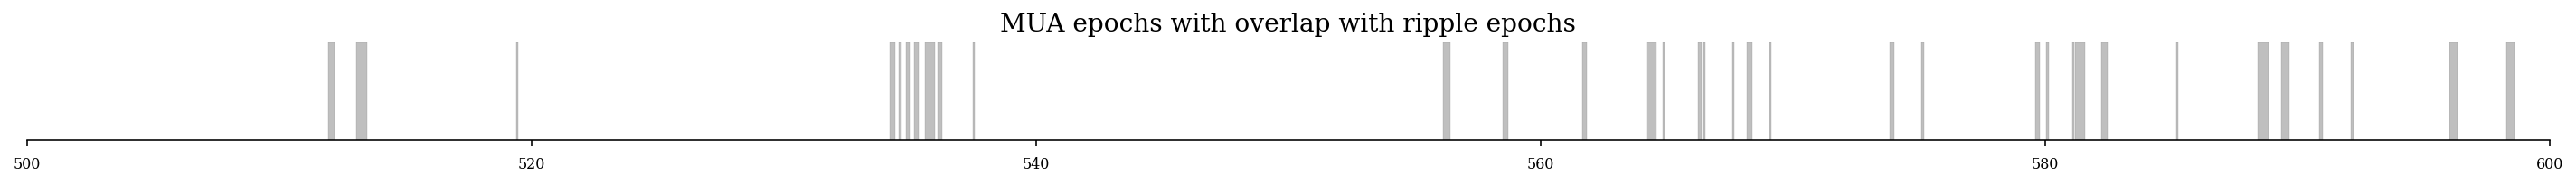

In [114]:
def overlap_intersect(epoch,interval):
    """
    Returns the epochs with overlap with interval
    Input:
        epoch: nelpy.EpochArray
            The epochs to check
        interval: nelpy.IntervalArray
            The interval to check for overlap
    Output:
        epoch: nelpy.EpochArray
            The epochs with overlap with interval
    """
    new_intervals = []
    for epa in (epoch):
        if any((interval.starts < epa.stop) & (interval.stops > epa.start)):
            new_intervals.append([epa.start, epa.stop])

    out = type(epoch)(new_intervals)
    out._domain = epoch.domain
    return out

# def overlap_expand_intersect(epoch,interval):
#     """
#     Returns the epochs with overlap with interval
#     Input:
#         epoch: nelpy.EpochArray
#             The epochs to check
#         interval: nelpy.IntervalArray
#             The interval to check for overlap
#     Output:
#         epoch: nelpy.EpochArray
#             The epochs with overlap with interval
#     """
#     new_intervals = []
#     for epa in (epoch):
#         if any((interval.starts < epa.stop) & (interval.stops > epa.start)):
#             new_intervals.append([epa.start, epa.stop])
#         else:
#             new_intervals.append([epa.start, epa.stop])


#     out = type(epoch)(new_intervals)
#     out._domain = epoch.domain
#     return out


import nelpy.plotting as npl
fig = plt.figure(figsize=(25,1))
ax = npl.epochplot(mua_epoch)
ax.set_xlim(mua_epoch.start, mua_epoch.stop)
npl.utils.clear_left_right(ax)
npl.utils.clear_top(ax)
npl.epochplot(ripple_epoch,color="r")
ax.set_xlim(500,600)
ax.set_title("MUA epochs and ripple epochs",fontsize=14)


fig = plt.figure(figsize=(25,1))
new_epoch = overlap_intersect(mua_epoch,ripple_epoch.expand(0.05))
ax = npl.epochplot(new_epoch)
npl.utils.clear_left_right(ax)
npl.utils.clear_top(ax)
ax.set_xlim(500,600)
ax.set_title("MUA epochs with overlap with ripple epochs",fontsize=14)

In [107]:
new_epoch
# ripple_epoch

<EpochArray at 0x2295481a7f0: 839 epochs> of length 1:58:622 minutes

In [90]:
import copy
def intersect(epoch, interval, *, boundaries=True):
    """Returns intersection (overlap) between current IntervalArray (epoch) and
        other interval array ('interval').
    """

    this = copy.deepcopy(epoch)
    new_intervals = []
    for epa in this:
        cand_ep_idx = np.argwhere((interval.starts < epa.stop) & (interval.stops > epa.start)).squeeze()
        if np.size(cand_ep_idx) > 0:
            for epb in interval[cand_ep_idx.tolist()]:
                new_interval = epoch._intersect(epa, epb, boundaries=boundaries)
                if not new_interval.isempty:
                    new_intervals.append([new_interval.start, new_interval.stop])
    out = type(epoch)(new_intervals)
    out._domain = epoch.domain
    return out

intersect(ripple_epoch, mua_epoch)    

<EpochArray at 0x22954734070: 827 epochs> of length 47.6216 seconds

In [80]:
from ipywidgets import interact, interactive, fixed, interact_manual

def epplt(epoch, expand=0, rshift=0, lshift=0, merge=False, complement=False):
    fig = plt.figure(figsize=(25,1))
    ax = fig.add_subplot(111)
    
    epoch = epoch + expand
    epoch = epoch >> rshift
    epoch = epoch << lshift
    if merge:
        epoch = epoch.merge()
    if complement:
        epoch = ~epoch
    ax = npl.epochplot(epoch)
    ax.set_xlim(epoch.domain.start, epoch.domain.stop)
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top(ax)


interact(epplt, epoch=fixed(ripple_epoch), expand=(-0.5,2.5,0.1), rshift=(0,12.5,0.5), lshift=(0,12,0.5), merge=False, complement=False);


interactive(children=(FloatSlider(value=0.0, description='expand', max=2.5, min=-0.5), FloatSlider(value=0.0, …